In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_16504\2014596840.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# download the dataset and normalize
custom_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5,.5,.5],[.5,.5,.5]),
])

trainset = torchvision.datasets.CIFAR10(root='CFAR', train=True, download=True, transform=custom_transform)
devset = torchvision.datasets.CIFAR10(root='CFAR', train=False, download=True, transform=custom_transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Check the data parameters
print(f"Data shape: {trainset.data.shape} -> 50000 images of 32x32 pixels with 3 color channels")
print(f"Data labels: {trainset.class_to_idx}")
print(f"{np.unique(trainset.targets)} -> Zero-indexed")
print(f"Data contains nans: {np.isnan(trainset.data).any()} -> Great!")

Data shape: (50000, 32, 32, 3) -> 50000 images of 32x32 pixels with 3 color channels
Data labels: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
[0 1 2 3 4 5 6 7 8 9] -> Zero-indexed
Data contains nans: False -> Great!


# Plot some figures

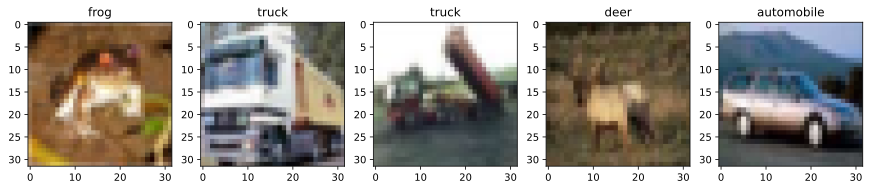

In [5]:
## PLot some figures
plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(trainset.data[i, :, :, :])
    plt.title(f"{list(trainset.class_to_idx.keys())[trainset.targets[i]]}")

plt.show()

# Create dataloaders

In [6]:
# Step 4: translate into dataloader objects
batchsize    = 128
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader   = DataLoader(devset, batch_size=len(devset))

# Create CNN

In [22]:
def get_conv_layer_output_size(input_size: (int, int), padding: (int, int), kernel_size: (int, int), stride: (int, int), pool_size: (int, int)) -> (int, int):
    dim0 = int((((input_size[0] + (2 * padding[0]) - kernel_size[0]) / stride[0]) + 1) / pool_size[0])
    dim1 = int((((input_size[1] + (2 * padding[1]) - kernel_size[1]) / stride[1]) + 1) / pool_size[1])
    return dim0, dim1


class MyCIFAR10AE(nn.Module):
    def __init__(self,printtoggle):
        super().__init__()

        # print toggle
        self.print = printtoggle

        ### -------------- feature map layers -------------- ###
        # first convolution layer
        self.conv1  = nn.Conv2d(3,16,4, padding=1, stride=2)

        # second convolution layer
        self.conv2  = nn.Conv2d(16,32,4, padding=1, stride=2)

        # Third convolution layer
        self.conv3  = nn.Conv2d(32,64,4,padding=1, stride=2)

        # first transpose convolution layer
        self.tconv1 = nn.ConvTranspose2d(64, 32, 4, padding=1, stride=2)

        # Second transpose convolution layer
        self.tconv2 = nn.ConvTranspose2d(32, 16, 4, padding=1, stride=2)

        # Third transpose convolution layer
        self.tconv3 = nn.ConvTranspose2d(16, 3, 4, padding=1, stride=2)

    def forward(self,x):
        # Encoding
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.tanh(self.conv3(x))

        # Decoding
        x = F.tanh(self.tconv1(x))
        x = F.tanh(self.tconv2(x))
        x = F.tanh(self.tconv3(x))
        return x

def create_the_net(print: bool = False):
    # create the model instance and copy to device (GPU)
    net = MyCIFAR10AE(print).to(device)

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.00001)

    return net,lossfun,optimizer

In [23]:
# test the model with one batch
net,lossfun,optimizer = create_the_net(True)

X,_ = next(iter(train_loader))
yHat = net(X.to(device)).cpu()

print("Input size:")
print(X.shape)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input size:
torch.Size([128, 3, 32, 32])

Output size:
torch.Size([128, 3, 32, 32])
 
Loss:
tensor(0.2688, grad_fn=<MseLossBackward0>)


C:\Users\lucan\Documents\github\signal-processing-problems-solved-in-python\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


# Function to train the model

In [24]:
# a function that trains the model
def function2trainTheModel(net=None):

    # number of epochs
    numepochs = 20

    numbatches = len(list(train_loader))

    # create a new model, or use exisiting net
    net_,lossfun,optimizer = create_the_net()
    if net is None:
        net = net_

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    devLoss  = torch.zeros(numepochs)
    # trainAcc  = torch.zeros(numepochs)
    # devAcc   = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        print(f"Starting epoch {epochi}...")

        # loop over training data batches
        net.train()
        batchLoss = torch.zeros(numbatches)
        # batchAcc  = torch.zeros(numbatches)
        batch_idx = 0
        for X,_ in train_loader:
            X = X.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, X)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and Accuracy from this batch
            batchLoss[batch_idx] = loss
            # corr = torch.corrcoef( torch.vstack( (yHat.flatten(), X.flatten()) ) )[0, 1]
            # batchAcc[batch_idx] = 100 * corr
            batch_idx += 1
        # end of batch loop...

        # and get average losses and accuracies rates across the batches
        trainLoss[epochi] = torch.mean(batchLoss)
        # trainAcc[epochi]  = 100*torch.mean(batchAcc)

        ### dev performance
        net.eval()
        X,_ = next(iter(dev_loader)) # extract X,y from test dataloader
        X = X.to(device)
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat, X)

        # get loss and accuracy rate from the devset
        devLoss[epochi] = loss
        # corr = torch.corrcoef( torch.vstack( (yHat.flatten(), X.flatten()) ) )[0, 1]
        # devAcc[epochi] = 100 * corr

        print(f"Training... Epoch [{epochi+1}/{numepochs}] done. Loss: {devLoss[epochi]:.3f}%")

    # end epochs

    # function output
    return trainLoss,devLoss,net

# Train the model

In [25]:
trainLoss,devLoss,net = function2trainTheModel()

Starting epoch 0...
Training... Epoch [1/20] done. Loss: 0.017%
Starting epoch 1...
Training... Epoch [2/20] done. Loss: 0.012%
Starting epoch 2...
Training... Epoch [3/20] done. Loss: 0.008%
Starting epoch 3...
Training... Epoch [4/20] done. Loss: 0.006%
Starting epoch 4...
Training... Epoch [5/20] done. Loss: 0.006%
Starting epoch 5...
Training... Epoch [6/20] done. Loss: 0.005%
Starting epoch 6...
Training... Epoch [7/20] done. Loss: 0.005%
Starting epoch 7...
Training... Epoch [8/20] done. Loss: 0.004%
Starting epoch 8...
Training... Epoch [9/20] done. Loss: 0.004%
Starting epoch 9...
Training... Epoch [10/20] done. Loss: 0.004%
Starting epoch 10...
Training... Epoch [11/20] done. Loss: 0.004%
Starting epoch 11...
Training... Epoch [12/20] done. Loss: 0.003%
Starting epoch 12...
Training... Epoch [13/20] done. Loss: 0.003%
Starting epoch 13...
Training... Epoch [14/20] done. Loss: 0.003%
Starting epoch 14...
Training... Epoch [15/20] done. Loss: 0.003%
Starting epoch 15...
Training

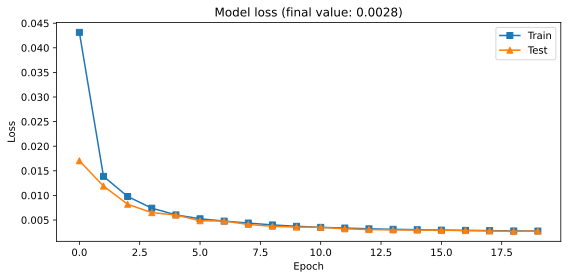

In [26]:
plt.figure(figsize=(8, 4))

plt.plot(trainLoss.detach(), 's-', label="Train")
plt.plot(devLoss.detach(), '^-', label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Model loss (final value: {devLoss[-1]:.4f})")

plt.tight_layout()
plt.show()

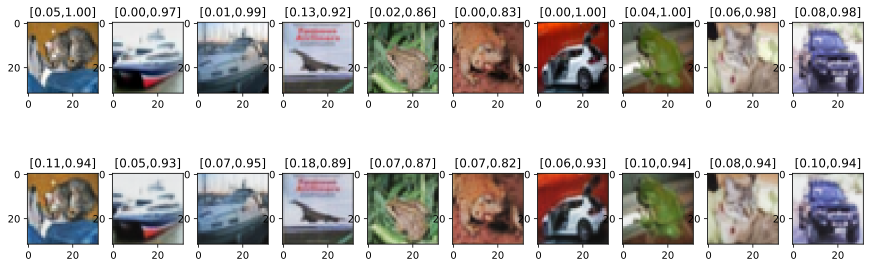

In [27]:
net.eval()
net.cpu()
fig, axs = plt.subplots(2, 10, figsize=(15, 5))

original_images, _ = next(iter(dev_loader))

for i in range(10):
    oi = original_images[i].numpy().transpose((1,2,0))
    oi = oi / 2 + 0.5

    axs[0][i].imshow(oi)
    axs[0][i].set_title(f"[{np.min(oi):.2f},{np.max(oi):.2f}]")

    yHat = net(original_images[i]).detach().numpy().transpose((1,2,0))
    yHat = yHat / 2 + 0.5

    axs[1][i].imshow(yHat)
    axs[1][i].set_title(f"[{np.min(yHat):.2f},{np.max(yHat):.2f}]")

plt.show()